In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from stack_segmentation.stack import Stack

In [5]:
from stack_segmentation.io import make_dataloader, collate_fn_basic

from stack_segmentation.training import (
    handle_stacks_data, 
    make_optimization_task, 
    train_loop
)

from stack_segmentation.pipeline_config import (
    dataloaders_conf,
    train_conf,
    model_config, 
    aug_config,
    optimizer_config,
    loss_config,
    scheduler_config,
)

In [6]:
from exp_config import data_conf

## Parameters to tune

In [7]:
train_conf['device'] = 'cuda:1'
# train_conf['device'] = 'cpu'
train_conf['num_epochs'] = 500
train_conf

{'num_epochs': 500, 'device': 'cuda:1'}

In [8]:
data_conf['conf_name'] = 'exp_basic_adamw_lr1e-3_epoch_300_resnet50_encoder_soft_aug_k_1_weight10_patch64_bs_256'
data_conf['patches'] = {
    'train': (64, 64, 1),
    'val': (64, 64, 1),
    'test': (64, 64, 1)
}
data_conf

{'conf_name': 'exp_basic_adamw_lr1e-3_epoch_300_resnet50_encoder_soft_aug_k_1_weight10_patch64_bs_256',
 'stacks': [{'path': '../../data/carb96558',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(250, 470, None))},
  {'path': '../../data/SoilB-2',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(240, 460, None))},
  {'path': '../../data/Urna_22',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 220, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(245, 455, None))},
  {'path': '../../data/carb96558',
   'slice_test': (slice(None, None, None),
    slice(None, None, None),
    slice(490, None, None))},
  {'path': '../../data/carb71',
   'slice_

In [9]:
model_config

{'source': 'qubvel',
 'model_type': 'Unet',
 'encoder_name': 'resnet50',
 'encoder_weights': 'imagenet'}

In [10]:
optimizer_config['opt_type'] = 'AdamW'
optimizer_config['lr'] = 1e-3
optimizer_config['weight_decay'] = 5e-5
optimizer_config['amsgrad'] = True
# optimizer_config['nesterov'] = True
optimizer_config

{'opt_type': 'AdamW',
 'lr': 0.001,
 'weight_decay': 5e-05,
 'amsgrad': True,
 'nesterov': False,
 'momentum': 0.9,
 'centered': False}

In [11]:
aug_config['aug_type'] = 'soft'
aug_config['k'] = 1
aug_config['original_height'] = 64
aug_config['original_width'] = 64
aug_config

{'aug_type': 'soft', 'original_height': 64, 'original_width': 64, 'k': 1}

In [12]:
loss_config =[
    {
        'loss': 'BCE', 
        'weight': 1, 
        'params': {'weight': [1, 10]}},
    {
        'loss': 'Dice',
        'weight': 2, 
        'params': {
            'mode': 'multiclass',
            'classes': [1], # может быть, этот параметр не нужен
            'log_loss': True,
            'from_logits': True,
            'smooth': 1,
            'eps': 1e-7
        }
    }
]
loss_config

[{'loss': 'BCE', 'weight': 1, 'params': {'weight': [1, 10]}},
 {'loss': 'Dice',
  'weight': 2,
  'params': {'mode': 'multiclass',
   'classes': [1],
   'log_loss': True,
   'from_logits': True,
   'smooth': 1,
   'eps': 1e-07}}]

In [14]:
dataloaders_conf['train']['batch_size'] = 32
dataloaders_conf['val']['batch_size'] = 32
dataloaders_conf['test']['batch_size'] = 32
dataloaders_conf

{'train': {'batch_size': 32, 'num_workers': 16, 'shuffle': True},
 'val': {'batch_size': 32, 'num_workers': 16, 'shuffle': False},
 'test': {'batch_size': 32, 'num_workers': 16, 'shuffle': True}}

## Prepare train, validation and test data

In [15]:
data_train, data_val, data_test = handle_stacks_data(**data_conf)

720it [00:01, 672.62it/s]
100%|██████████| 720/720 [00:07<00:00, 95.58it/s] 
33120it [00:00, 241057.81it/s]
31680it [00:00, 163036.29it/s]
700it [00:00, 847.02it/s]
100%|██████████| 700/700 [00:06<00:00, 102.69it/s]
27830it [00:00, 144244.41it/s]
26620it [00:00, 243222.74it/s]
710it [00:00, 849.75it/s]
100%|██████████| 710/710 [00:07<00:00, 98.55it/s] 
31680it [00:00, 141759.02it/s]
30240it [00:00, 128289.40it/s]
720it [00:00, 830.22it/s]
100%|██████████| 720/720 [00:07<00:00, 96.64it/s] 
33120it [00:00, 242938.42it/s]
720it [00:00, 814.63it/s]
100%|██████████| 720/720 [00:07<00:00, 95.23it/s] 
103680it [00:00, 168593.01it/s]
700it [00:01, 690.47it/s]
100%|██████████| 700/700 [00:06<00:00, 100.04it/s]
84700it [00:00, 230932.20it/s]
509it [00:00, 1148.33it/s]
100%|██████████| 509/509 [00:02<00:00, 196.92it/s]
32576it [00:00, 93570.01it/s]
700it [00:00, 844.10it/s]
100%|██████████| 700/700 [00:06<00:00, 101.64it/s]
84700it [00:00, 224649.48it/s]
700it [00:00, 806.90it/s]
100%|██████████|

In [16]:
len(data_train), len(data_val), len(data_test)

(92630, 88540, 11)

In [17]:
dataloader_train = make_dataloader(
    samples=data_train, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    aug_config=aug_config,
    **dataloaders_conf['train']
)

dataloader_val = make_dataloader(
    samples=data_val, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    **dataloaders_conf['val']
)

dataloaders_test = {
    name: make_dataloader(
        samples=data, 
        collate_fn=collate_fn_basic,
        model_config=model_config,
        **dataloaders_conf['test']
    ) for name, data in data_test.items()}

## Create model and metrics

In [18]:
device = 'cuda:1'
# device = 'cpu'

In [19]:
model, criterion, optimizer, scheduler = make_optimization_task(
    device,
    model_config=model_config,
    loss_config=loss_config, 
    optimizer_config=optimizer_config,
    scheduler_config=scheduler_config)

## Run experiment

In [20]:
from stack_segmentation.metrics import accuracy, precision, recall, f1, pr_auc, iou

In [21]:
metrics = {
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'pr_auc': pr_auc, 
    'iou': iou,
}

In [22]:
results = train_loop(
    model=model,
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    dataloaders_test=dataloaders_test,
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    metrics=metrics,
    exp_name=data_conf['conf_name'],
    **train_conf)

  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 0...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.049124


100%|██████████| 2767/2767 [00:52<00:00, 52.35it/s]


Mean val loss: 0.028934


  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 1...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.028981


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.037783
EarlyStopping counter: 1 out of 15
Epoch 2...


100%|██████████| 2767/2767 [00:53<00:00, 51.96it/s]


Mean val loss: 0.027894


  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 3...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.02608


100%|██████████| 2767/2767 [00:53<00:00, 51.95it/s]


Mean val loss: 0.025836


  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 4...


 54%|█████▍    | 1561/2895 [01:42<01:28, 15.01it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.023947


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.029132
EarlyStopping counter: 1 out of 15
Epoch 9...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.023677


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.028468
EarlyStopping counter: 2 out of 15
Epoch 10...


  2%|▏         | 55/2895 [00:04<03:06, 15.21it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.024282
EarlyStopping counter: 2 out of 15
Epoch 14...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.023869


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.026956
EarlyStopping counter: 3 out of 15
Epoch 15...


 49%|████▉     | 1429/2895 [01:32<01:32, 15.90it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.022352


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.023121
EarlyStopping counter: 1 out of 15
Epoch 20...


 90%|████████▉ | 2597/2895 [02:49<00:19, 15.33it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021863


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.022346
EarlyStopping counter: 6 out of 15
Epoch 25...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021878


 69%|██████▊   | 1900/2767 [00:36<00:15, 54.20it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021604


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.022762
EarlyStopping counter: 4 out of 15
Epoch 30...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021529


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.022381
EarlyStopping counter: 5 out of 15
Epoch 31...


 17%|█▋        | 495/2895 [00:33<02:34, 15.49it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021482


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.022356
EarlyStopping counter: 6 out of 15
Epoch 32...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021441


100%|██████████| 2767/2767 [00:53<00:00, 51.94it/s]


Mean val loss: 0.021675


  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 33...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021404


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.022471
EarlyStopping counter: 1 out of 15
Epoch 34...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021339


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.022209
EarlyStopping counter: 2 out of 15
Epoch 35...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.02133


100%|██████████| 2767/2767 [00:53<00:00, 51.95it/s]


Mean val loss: 0.021675


  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 36...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.02131


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.023308
EarlyStopping counter: 1 out of 15
Epoch 37...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021299


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.022195
EarlyStopping counter: 2 out of 15
Epoch 38...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.02123


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.022302
EarlyStopping counter: 3 out of 15
Epoch 39...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.02124


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021855
EarlyStopping counter: 4 out of 15
Epoch 40...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021199


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.022555
EarlyStopping counter: 5 out of 15
Epoch 41...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021123


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.02177
EarlyStopping counter: 6 out of 15
Epoch 42...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021069


100%|██████████| 2767/2767 [00:53<00:00, 51.76it/s]


Mean val loss: 0.021584


  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 43...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021025


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021764
EarlyStopping counter: 1 out of 15
Epoch 45...


 84%|████████▍ | 2439/2895 [02:38<00:30, 15.03it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020991


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021878
EarlyStopping counter: 3 out of 15
Epoch 47...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020969


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021621
EarlyStopping counter: 4 out of 15
Epoch 48...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020928


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.022584
EarlyStopping counter: 5 out of 15
Epoch 49...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020913


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.030449
EarlyStopping counter: 6 out of 15
Epoch 50...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020908


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021801
EarlyStopping counter: 7 out of 15
Epoch 51...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020869


100%|██████████| 2767/2767 [00:53<00:00, 51.79it/s]


Mean val loss: 0.021164


  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 52...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020855


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021497
EarlyStopping counter: 1 out of 15
Epoch 53...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020806


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021538
EarlyStopping counter: 2 out of 15
Epoch 54...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020818


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021689
EarlyStopping counter: 3 out of 15
Epoch 55...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.02081


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021295
EarlyStopping counter: 4 out of 15
Epoch 56...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020788


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.02282
EarlyStopping counter: 5 out of 15
Epoch 57...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020734


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021494
EarlyStopping counter: 6 out of 15
Epoch 58...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020746


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021288
EarlyStopping counter: 7 out of 15
Epoch 59...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020688


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021566
EarlyStopping counter: 8 out of 15
Epoch 60...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020705


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021586
EarlyStopping counter: 9 out of 15
Epoch 61...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020694


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021559
EarlyStopping counter: 10 out of 15
Epoch 62...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020726


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021358
EarlyStopping counter: 11 out of 15
Epoch 63...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020665


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.025835
EarlyStopping counter: 12 out of 15
Epoch 64...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020625


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021483
EarlyStopping counter: 13 out of 15
Epoch 65...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020608


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021459
EarlyStopping counter: 14 out of 15
Epoch 66...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020593


  0%|          | 0/1035 [00:00<?, ?it/s]

Mean val loss: 0.021234
EarlyStopping counter: 15 out of 15


 71%|███████   | 1876/2647 [05:18<02:15,  5.67it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 22%|██▏       | 696/3195 [01:53<06:33,  6.35it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 74%|███████▍  | 1955/2647 [05:22<02:23,  4.83it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_

## Dump experiment results

In [23]:
import pickle
import json

In [24]:
p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
with open(p, 'wb') as f:
    pickle.dump(results, f)

In [28]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'rb') as f:
#     results = pickle.load(f)

In [11]:
import torch
model.load_state_dict(torch.load('./{}.pt'.format(data_conf['conf_name'])))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Train and validation losses

In [25]:
from itertools import chain

In [26]:
train_losses = list(chain(*[item for item in results['train_losses']]))
val_losses = list(chain(*[item for item in results['val_losses']]))

In [27]:
def moving_average(a, n=5) :
    ret = np.cumsum([a[0]] * (n - 1) + a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

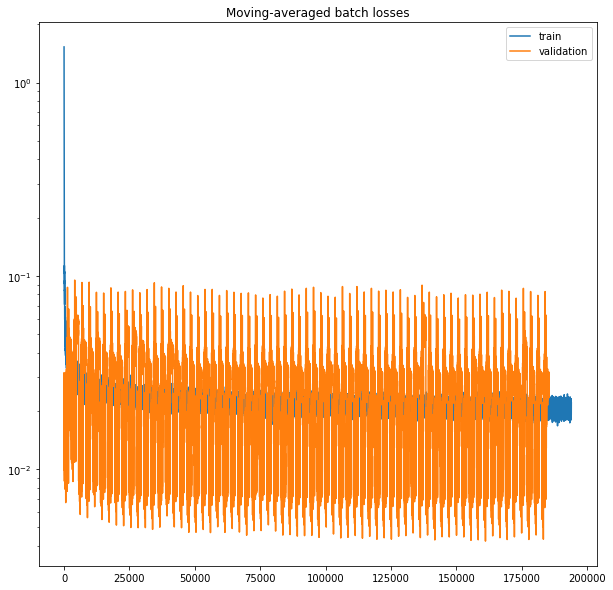

In [28]:
plt.figure(figsize=(10, 10))
plt.title('Moving-averaged batch losses')
plt.plot(np.arange(len(train_losses)), moving_average(train_losses), label='train')
plt.plot(np.arange(len(val_losses)), moving_average(val_losses), label='validation')

plt.legend(loc='best')
plt.yscale('log')

# plt.ylim([1e-2, 1])
plt.show()

In [29]:
mean_train_loss = [np.mean(item) for item in results['train_losses']]
mean_val_loss = [np.mean(item) for item in results['val_losses']]

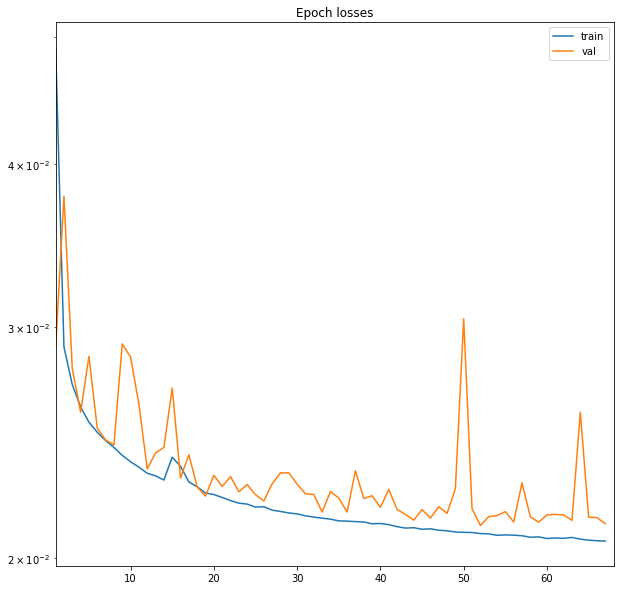

In [30]:
plt.figure(figsize=(10, 10))
plt.title('Epoch losses')
plt.plot(np.arange(len(mean_train_loss)) + 1, mean_train_loss, label='train')
plt.plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, label='val')

plt.yscale('log')
plt.legend(loc='best')

plt.xlim([1, len(mean_train_loss) + 1])
plt.show()

## Results

In [31]:
import pandas as pd

In [32]:
from visualization_utils import make_df

In [33]:
df = make_df(results, model_name='basic')
df

,accuracy,precision,recall,f1,pr_auc,iou,stack,model
0,0.995560,0.942069,0.996435,0.968489,0.998492,0.938904,carb96558,basic
1,0.984840,0.884424,0.997730,0.937667,0.988197,0.882648,carb71,basic
2,0.982579,0.934150,0.927308,0.930716,0.978964,0.870411,carbRNF,basic
3,0.994698,0.990572,0.942636,0.966010,0.997355,0.934254,SPE_carb10_58_box3,basic
4,0.992397,0.951313,0.938396,0.944810,0.992299,0.895393,SoilAh-1,basic
5,0.995239,0.912070,0.989316,0.949124,0.995581,0.903174,SoilB-2,basic
6,0.992348,0.993165,0.929976,0.960532,0.989033,0.924061,TeTree_subset1,basic
7,0.994057,0.993427,0.949383,0.970906,0.992379,0.943456,TiTree_subset2,basic
8,0.991585,0.942829,0.996949,0.969134,0.998315,0.940116,Urna_22,basic
9,0.988907,0.945657,0.985220,0.965033,0.997052,0.932429,Urna_30,basic


In [34]:
print('Mean   IOU: {:.5}'.format(df['iou'].mean()))
print('Std    IOU: {:.5}'.format(df['iou'].std()))
print('Min    IOU: {:.5}'.format(df['iou'].min()))
print('Median IOU: {:.5}'.format(df['iou'].median()))

Mean   IOU: 0.91567
Std    IOU: 0.025255
Min    IOU: 0.87041
Median IOU: 0.92406


## Check loss to loss ratio

In [35]:
criterion.losses

(WeightedLoss(
   (loss): CrossEntropyLoss()
 ), WeightedLoss(
   (loss): DiceLoss()
 ))

In [36]:
from stack_segmentation.training import make_joint_loss

In [37]:
import torch

In [38]:
# loss_config[0] = {'loss': 'BCE',
#   'weight': 0.5,
#   'params': {}}
# loss_config
# crit = make_joint_loss(device=device, loss_config=loss_config)

In [39]:
crit = criterion
a = []
b = []
for i, (x, y) in enumerate(dataloader_val):
    if i > 100:
        break
    pred = model(torch.from_numpy(x).to(device))
    y = torch.from_numpy(y).to(device)
    a.append(crit.losses[0](pred, y).cpu().data.numpy())
    b.append(crit.losses[1](pred, y).cpu().data.numpy())

In [40]:
print('Mean 0 loss: {:.4f}\nMean 1 loss: {:.4f}\nMean of ratios: {:.4f}\nRatio of means: {:.4f}'
      .format(np.mean(a), np.mean(b), np.mean(np.array(a) / np.array(b)), np.mean(a) / np.mean(b)))

Mean 0 loss: 0.0093
Mean 1 loss: 0.0043
Mean of ratios: 2.5077
Ratio of means: 2.1461
